<a href="https://colab.research.google.com/github/PRsant90/Challenge_datos_2_parte_2/blob/main/Telecomx_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar liberias

In [1]:
# Instalar la librería imblearn
%pip install imblearn

# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

Cargar datos anteriores

In [6]:
df = pd.read_csv('/content/df_final parte 1.csv')
df

,id,cancelacion,genero,mayor_de_65,pareja,dependientes,meses_de_contrato,servicio_telefonico,lineas_multiples,servicio_internet,...,soporte_tecnico,servicio_tv,servicio_peliculas,tipo_contrato,facturas_electronicas,metodo_pago,total_pagos_mensuales,ingreso_total_cliente,cuentas_diarias,tiempo_de_contrato
0,0002-ORFBO,0,female,0,1,1,9.0,1,0,dsl,...,1,1,0,one year,1,mailed check,65.60,593.30,2.186667,9.044207
1,0003-MKNFE,0,male,0,0,0,9.0,1,1,dsl,...,0,0,1,month-to-month,0,mailed check,59.90,542.40,1.996667,9.055092
2,0004-TLHLJ,1,male,0,0,0,4.0,1,0,fiber optic,...,0,0,0,month-to-month,1,electronic check,73.90,280.85,2.463333,3.800406
3,0011-IGKFF,1,male,1,1,0,13.0,1,0,fiber optic,...,0,1,1,month-to-month,1,electronic check,98.00,1237.85,3.266667,12.631122
4,0013-EXCHZ,1,female,1,1,0,3.0,1,0,fiber optic,...,1,1,0,month-to-month,1,mailed check,83.90,267.40,2.796667,3.187128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,0,female,0,0,0,13.0,1,0,dsl,...,1,0,0,one year,0,mailed check,55.15,742.90,1.838333,13.470535
7039,9992-RRAMN,1,male,0,1,0,22.0,1,1,fiber optic,...,0,0,1,month-to-month,1,electronic check,85.10,1873.70,2.836667,22.017626
7040,9992-UJOEL,0,male,0,0,0,2.0,1,0,dsl,...,0,0,0,month-to-month,1,mailed check,50.30,92.75,1.676667,1.843936
7041,9993-LHIEB,0,male,0,1,1,67.0,1,0,dsl,...,1,0,1,two year,0,mailed check,67.85,4627.65,2.261667,68.204127


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7043 non-null   object 
 1   cancelacion            7043 non-null   int64  
 2   genero                 7043 non-null   object 
 3   mayor_de_65            7043 non-null   int64  
 4   pareja                 7043 non-null   int64  
 5   dependientes           7043 non-null   int64  
 6   meses_de_contrato      7043 non-null   float64
 7   servicio_telefonico    7043 non-null   int64  
 8   lineas_multiples       7043 non-null   int64  
 9   servicio_internet      7043 non-null   object 
 10  seguridad_en_linea     7043 non-null   int64  
 11  Soporte_en_linea       7043 non-null   int64  
 12  protecc_disp           7043 non-null   int64  
 13  soporte_tecnico        7043 non-null   int64  
 14  servicio_tv            7043 non-null   int64  
 15  serv

Eliminación de columnas Irrelevantes para el analisis o modelo predictivo


##Las columnas que no son relevantes para este analisis o que no tienen impacto son:##

- Ingreso total cliente.
  Suele ser simplemente meses_de_contrato * total_pagos_mensuales. Es redundante.

- tiempo_de_contrato:
  Es una transformación directa de meses_de_contrato (quizá en años o meses normalizados). Si es así, también se puede eliminar.

- cuentas_diarias:
  Métrica derivada (por ejemplo, ingreso_total_cliente / días_contratados). Habría que revisar, pero en muchos casos es solo una variable calculada a partir de otras.

In [9]:
columnas_irrelevantes = [
    'id',
    'ingreso_total_cliente',
    'tiempo_de_contrato',
    'cuentas_diarias'
]
df = df.drop(columns=columnas_irrelevantes)

print(df.columns.tolist())

['cancelacion', 'genero', 'mayor_de_65', 'pareja', 'dependientes', 'meses_de_contrato', 'servicio_telefonico', 'lineas_multiples', 'servicio_internet', 'seguridad_en_linea', 'Soporte_en_linea', 'protecc_disp', 'soporte_tecnico', 'servicio_tv', 'servicio_peliculas', 'tipo_contrato', 'facturas_electronicas', 'metodo_pago', 'total_pagos_mensuales']


One hot encoding

In [14]:
cat_cols = ['genero', 'servicio_internet', 'tipo_contrato', 'metodo_pago']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)

print(df_encoded.head())
print(df_encoded.columns)

   cancelacion  mayor_de_65  pareja  dependientes  meses_de_contrato  \
0            0            0       1             1                9.0   
1            0            0       0             0                9.0   
2            1            0       0             0                4.0   
3            1            1       1             0               13.0   
4            1            1       1             0                3.0   

   servicio_telefonico  lineas_multiples  seguridad_en_linea  \
0                    1                 0                   0   
1                    1                 1                   0   
2                    1                 0                   0   
3                    1                 0                   0   
4                    1                 0                   0   

   Soporte_en_linea  protecc_disp  ...  facturas_electronicas  \
0                 1             0  ...                      1   
1                 0             0  ...              

In [15]:
df = df.rename(columns={'genero_1': 'genero'})
print(df.columns)

Index(['cancelacion', 'genero', 'mayor_de_65', 'pareja', 'dependientes',
       'meses_de_contrato', 'servicio_telefonico', 'lineas_multiples',
       'servicio_internet', 'seguridad_en_linea', 'Soporte_en_linea',
       'protecc_disp', 'soporte_tecnico', 'servicio_tv', 'servicio_peliculas',
       'tipo_contrato', 'facturas_electronicas', 'metodo_pago',
       'total_pagos_mensuales'],
      dtype='object')


Verificación de la Proporción de Cancelación (Churn)

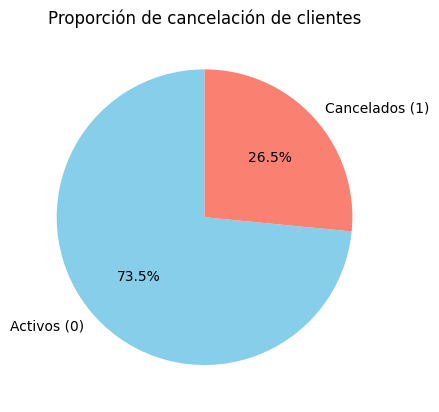

In [17]:
# Contar cantidad de clientes que cancelaron (1) y que permanecieron (0)
conteo = df['cancelacion'].value_counts()

# Mostrar proporción
proporcion = df['cancelacion'].value_counts(normalize=True)

plt.pie(proporcion,
        labels=['Activos (0)', 'Cancelados (1)'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'salmon'])

plt.title('Proporción de cancelación de clientes')
plt.show()


#Como vimos en el analisis del challenge anterior existe una preocupante salida de clientes de la empresa.

Analisis de correlaciones


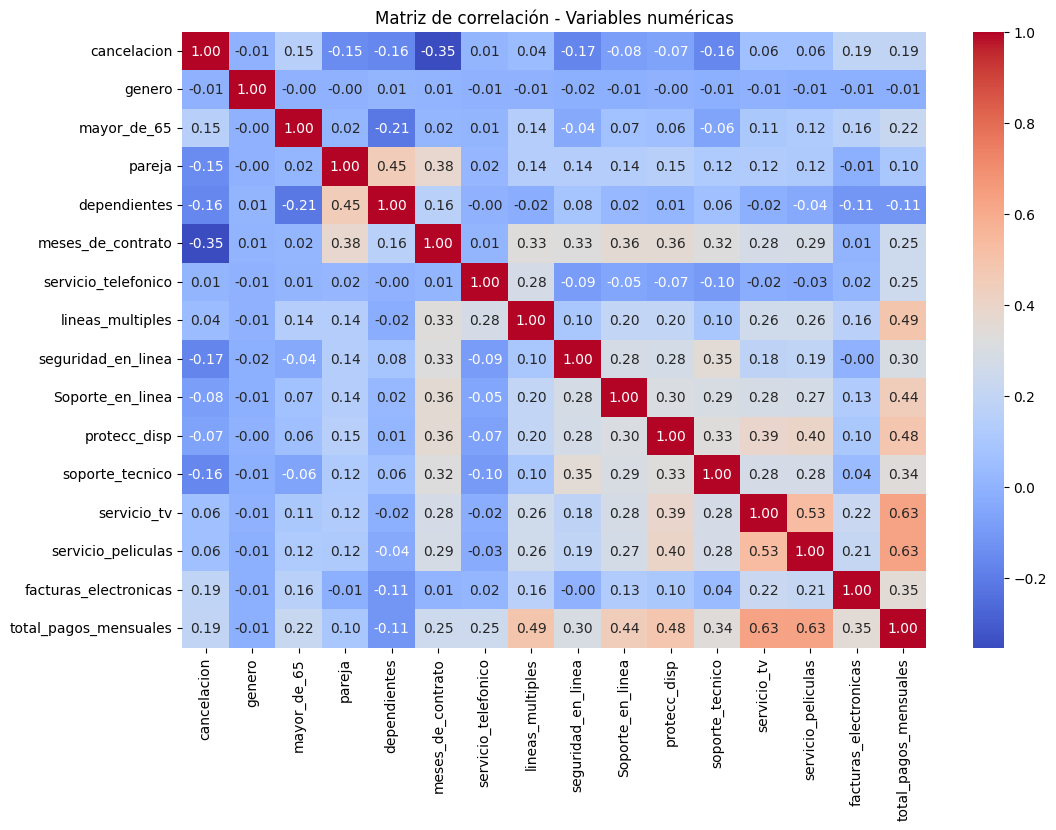

Correlación con cancelacion:
cancelacion              1.000000
total_pagos_mensuales    0.193356
facturas_electronicas    0.191825
mayor_de_65              0.150889
servicio_tv              0.063228
servicio_peliculas       0.061382
lineas_multiples         0.040102
servicio_telefonico      0.011942
genero                  -0.008612
protecc_disp            -0.066160
Soporte_en_linea        -0.082255
pareja                  -0.150448
dependientes            -0.164221
soporte_tecnico         -0.164674
seguridad_en_linea      -0.171226
meses_de_contrato       -0.352229
Name: cancelacion, dtype: float64


In [40]:
# 1) Seleccionar solo columnas numéricas
df_num = df.select_dtypes(include=['int64', 'float64'])

# 2) Calcular correlación
corr = df_num.corr()

# 3) Visualizar matriz completa
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlación - Variables numéricas")
plt.show()

# 4) Ver correlación de cada variable con 'cancelacion'
print("Correlación con cancelacion:")
print(corr['cancelacion'].sort_values(ascending=False))